---
## Aim

In this notebook, the goal is to:

- **Assess the quality** of the acquired data.
- **Exclude redundant or faulty data entries**.
- **Determine appropriate parameters** for peak detection.

---


---
## Data Quality Check

- **P01**: Sampling frequency (`fs`) was 40 Hz →  
  → Used `segment_len_threshold = 100`, `distance = 400`  
  → Slight shift observed in speed, but data successfully extracted.

**Sampling frequency changed to 100 Hz from P02 to P15.**

Using the following settings, data could be successfully extracted:

- **P02**: `segment_len_threshold = 100`, `distance = 400`
- **P03**: `segment_len_threshold = 200`, `distance = 500`
- **P04**: `segment_len_threshold = 200`, `distance = 500`
- **P05**: `segment_len_threshold = 200`, `distance = 500`
- **P06**: `segment_len_threshold = 200`, `distance = 500`
- **P07**: `segment_len_threshold = 200`, `distance = 500`
- **P08**: `segment_len_threshold = 200`, `distance = 500`
- **P09**: `segment_len_threshold = 200`, `distance = 500`
- **P10**: `segment_len_threshold = 200`, `distance = 500`
- **P11**: `segment_len_threshold = 200`, `distance = 500`
- **P12**: `segment_len_threshold = 200`, `distance = 500`
- **P13**: `segment_len_threshold = 200`, `distance = 500`
- **P14**: `segment_len_threshold = 200`, `distance = 500`
- **P15**: `segment_len_threshold = 100`, `distance = 400`

---




# Import Libraries

---

In [1]:
from pre_processing.pre_processing_utils import *
from toolbox import Protocol
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

In [2]:
base_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Final_Measurements/P15"

In [3]:
protocol = Protocol(base_dir, verbose=False)

sections = {
    "Participant Information": protocol.Participant,
    "Isokinetic Settings": protocol.IsokineticMeasurement,
    "EIT Settings": protocol.EITMeasurement
}

for title, content in sections.items():
    print(f"\n{'=' * 15} {title} {'=' * 15}")
    print(content)



=============== Participant Information ===============
Participant(Number='P15', age='20', gender='female', leg='right')

=============== Isokinetic Settings ===============
IsokineticMeasurement(rotation_velocity=30, force_levels=array([60, 60, 50, 50, 20, 20, 30, 30, 80, 80, 70, 70, 40, 40]))

=============== EIT Settings ===============
EITMeasurement(excitation_frequency=125000, burst_count=0, amplitude=1, frame_rate=40, n_el=16, injection_skip=5)


---
# Step 1

Extract the torque, postion, speed data from `.txt` file generated by isoforce device. First stage is to extract essential data and stored them as `.csv` for feasibility of reading the data. 


---

In [4]:
iso_raw_DF = generate_DF(file_path=base_dir)


Cleaned data saved to /Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Final_Measurements/P15/iso_raw_data.csv


### Now lets take a look at this signals stored in Isoforce

`IsoForceraw` class make preprocessing the data automatically and in a compact way.


Applying low-pass filter to torque and angle data.


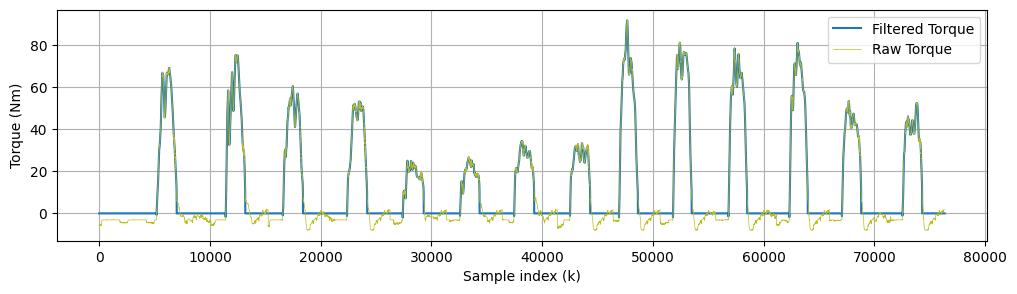

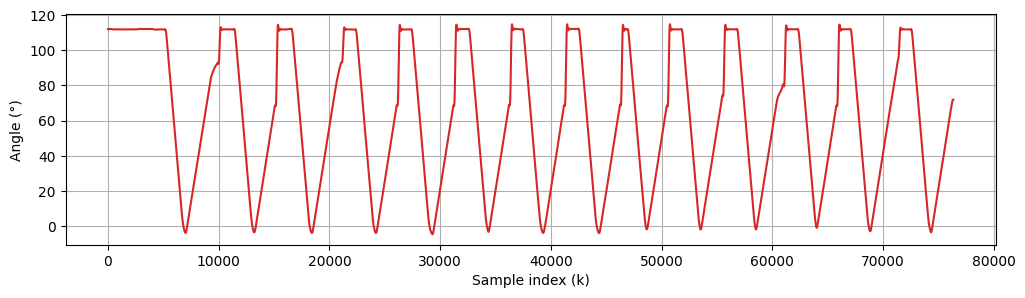

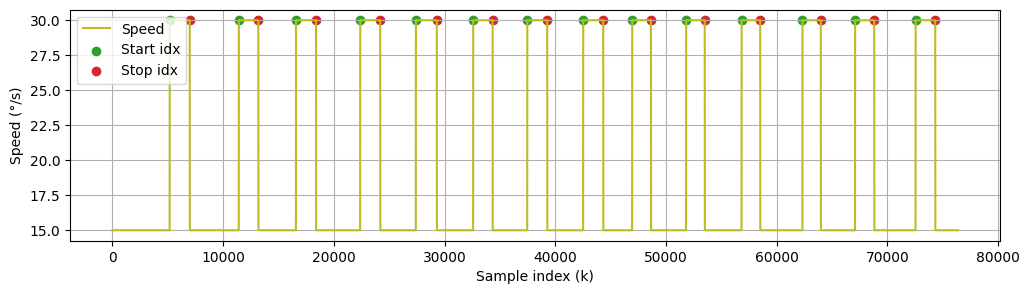

In [5]:
isoforce_iso = IsoForceRAW(iso_raw_DF, LP_filter_enabled=True, Protocol=protocol)
isoforce_iso.plot_torque()
isoforce_iso.plot_angle()
isoforce_iso.plot_speed()

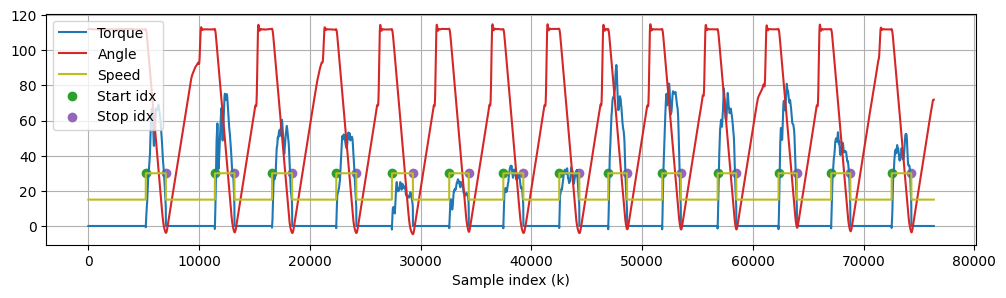

In [6]:
isoforce_iso.plot_data()


## Observation for `P15` from Isoforce Source

1. All three channels [Torque, Angle, and Speed] was succussfully recorded and plotted
2. After applying the LPF, all start,stop idx was extracted correctly

The quality of this test subjects was checked ✅

---

##

## Plot Extracted  torque and position segments in one plot

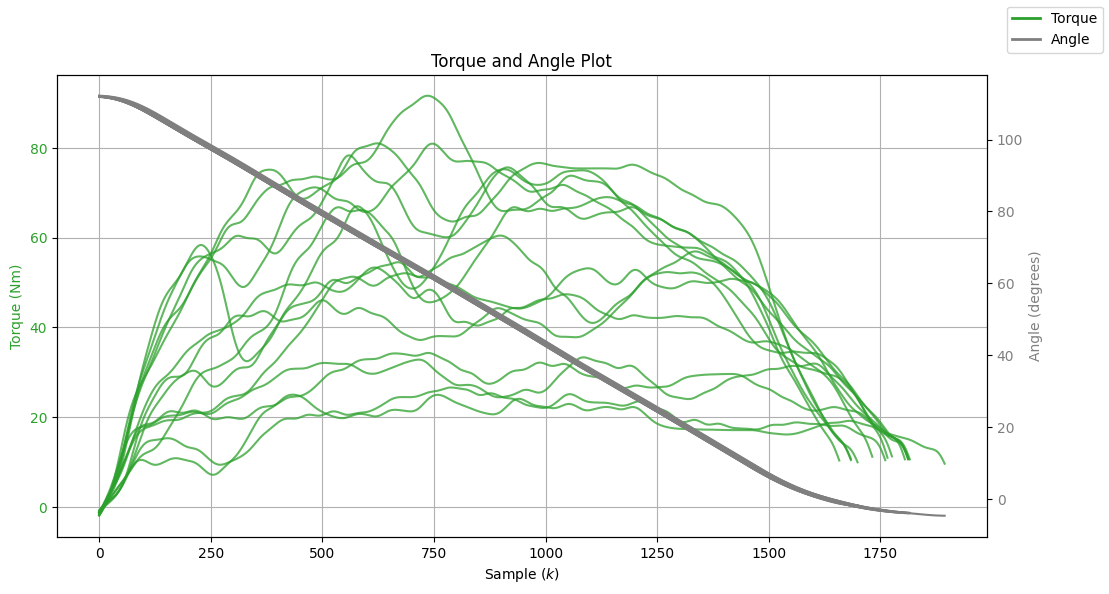

In [7]:
fig, ax1 = plt.subplots(figsize=(12,6)) 

# Plot Torque on the primary y-axis
for idx in range(len(isoforce_iso.torque_segments.keys())):
    ax1.plot(isoforce_iso.torque_segments[f"T_seg_{idx}"], "C2", alpha=0.75)

ax1.set_xlabel("Sample ($k$)")
ax1.set_ylabel("Torque (Nm)", color="C2")
ax1.tick_params(axis="y", labelcolor="C2")
ax1.grid()

# Create a second y-axis for Angle
ax2 = ax1.twinx()  
for idx in range(len(isoforce_iso.angle_segments.keys())):
    ax2.plot(isoforce_iso.angle_segments[f"A_seg_{idx}"], "C7")

ax2.set_ylabel("Angle (degrees)", color="C7")
ax2.tick_params(axis="y", labelcolor="C7")

custom_lines = [
    Line2D([0], [0], color="C2", lw=2, label="Torque"),
    Line2D([0], [0], color="C7", lw=2, label="Angle")
]
fig.legend(handles=custom_lines, loc="upper right")


plt.title("Torque and Angle Plot")
plt.show()


---
# Step 2:
Now again all three channells are checked and plotted. however here the data is from NI chipcard.

here, `IsoforcePy` here process the data such as filterring and extracting the data

---

# Isoforce Data Acquisition from NI Chip

The NI chip is equipped with three channels: P, T, and S. Each channel is associated with specific measurement parameters, including a factor and offset, as detailed below:

- **Channel 1 (P):** Angle  
  - Factor: 54  
  - Offset: 12  

- **Channel 2 (T):** Torque  
  - Factor: 150  
  - Offset: 25  

- **Channel 3 (S):** Speed  
  - Factor: 108  
  - Offset: -3  

however, it was decided to only converted the all data into 0-1

---

In [31]:
isoforce_py = IsoForcePy(base_dir, Protocol=protocol, LP_filter_enabled=True, over_UTC=False, scale_0_1=True, segment_len_threshold=100, distance=300)


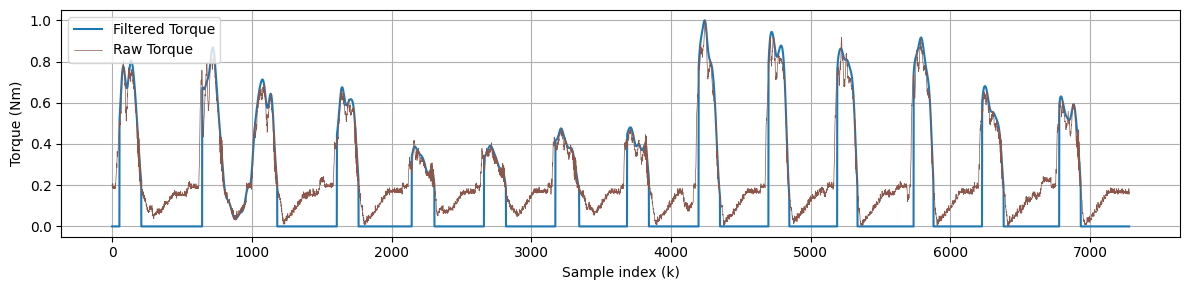

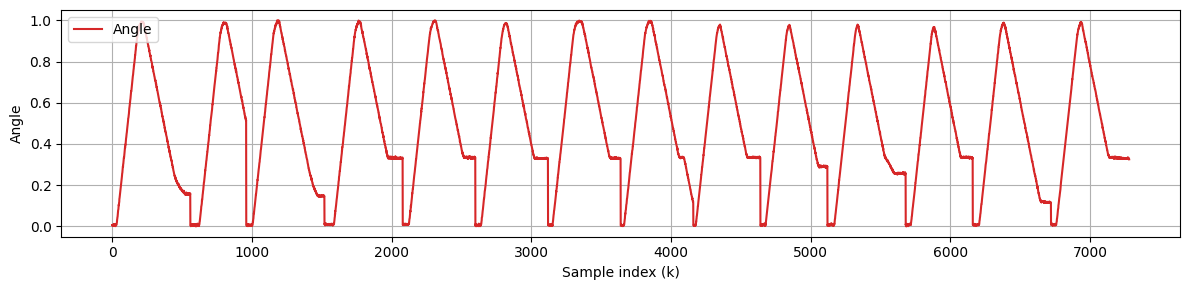

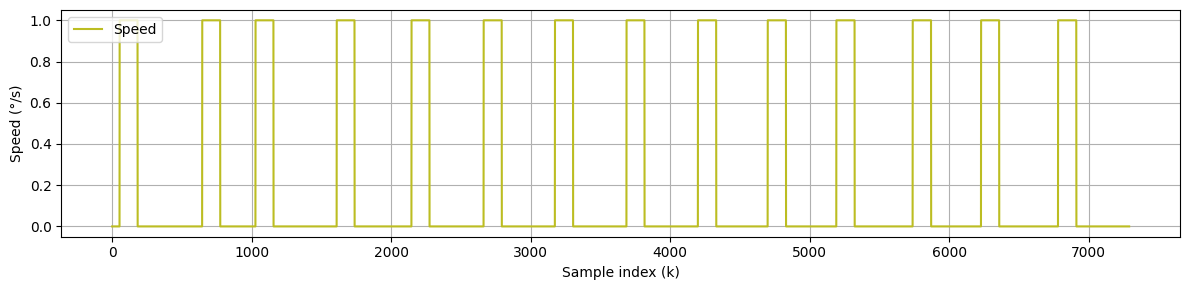

In [32]:
isoforce_py.plot_torque()
isoforce_py.plot_angle()
isoforce_py.plot_speed()


## It can be conclude that, from NI card , all triall can be extracted succussfully as well.

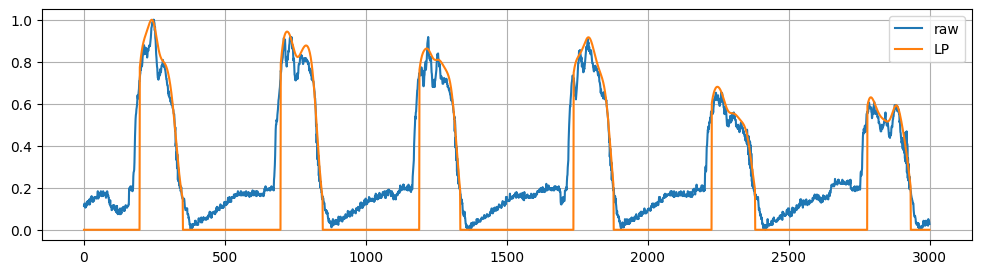

In [22]:
plt.figure(figsize=(12, 3))
plt.plot((isoforce_py.torque_raw[4000:7000]), label="raw")
plt.plot((isoforce_py.torque[4000:7000]), label="LP")
plt.legend()
plt.grid()

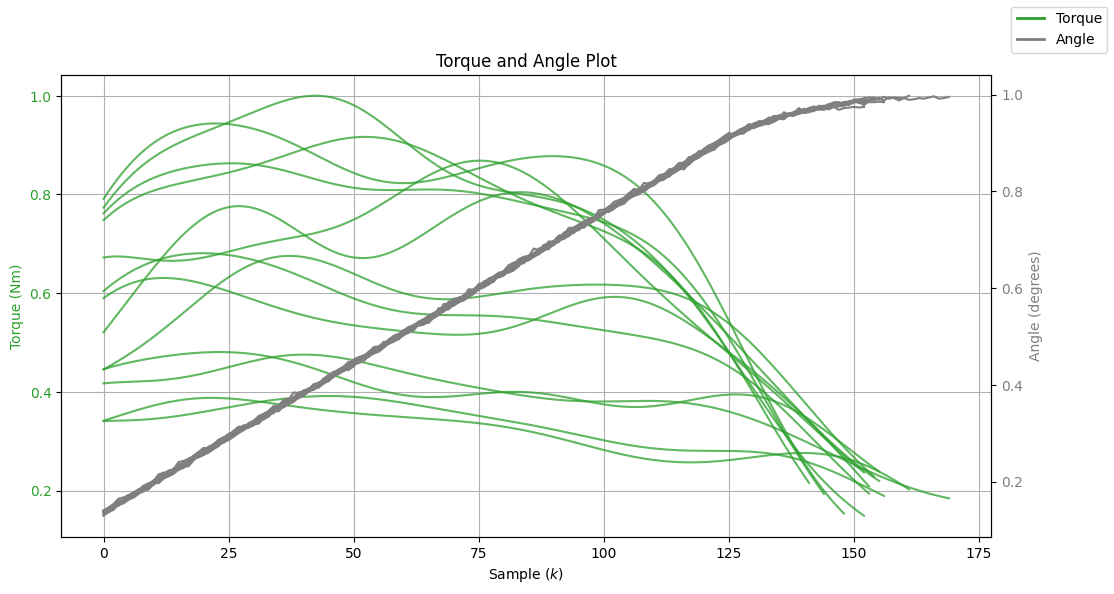

In [34]:
fig, ax1 = plt.subplots(figsize=(12,6)) 

# Plot Torque on the primary y-axis
for idx in range(len(isoforce_py.torque_segments.keys())):
    if len(isoforce_py.torque_segments[f"T_seg_{idx}"])> 300:
        continue
    ax1.plot(isoforce_py.torque_segments[f"T_seg_{idx}"], "C2", alpha=0.75)

ax1.set_xlabel("Sample ($k$)")
ax1.set_ylabel("Torque (Nm)", color="C2")
ax1.tick_params(axis="y", labelcolor="C2")
ax1.grid()

# Create a second y-axis for Angle
ax2 = ax1.twinx()  
for idx in range(len(isoforce_py.angle_segments.keys())):
    if len(isoforce_py.torque_segments[f"T_seg_{idx}"])> 300:
        continue
    ax2.plot(isoforce_py.angle_segments[f"A_seg_{idx}"], "C7")

ax2.set_ylabel("Angle (degrees)", color="C7")
ax2.tick_params(axis="y", labelcolor="C7")

custom_lines = [
    Line2D([0], [0], color="C2", lw=2, label="Torque"),
    Line2D([0], [0], color="C7", lw=2, label="Angle")
]
fig.legend(handles=custom_lines, loc="upper right")


plt.title("Torque and Angle Plot")
plt.show()
